A_pontoon: 116.64000000000001
V_pontoon_large: 8433.072
V_pontoon_small: 5913.648
V_column: 772.2136844284954
V_platform: 31782.294737713983
M_platform: 32576852.106156833
c_m: 1.51
A_R: 91.60884177867838
hydro_mass_per_length: 141787.58486294947
added_mass_large: 10251242.385591246
added_mass_small: 7188630.552551538
total_added_mass: 34879745.87628557
M: 32576852.106156833
M_a: 34879745.87628557
Natural frequency ω_N = 0.2445 rad/s, period T_N = 25.6946 s


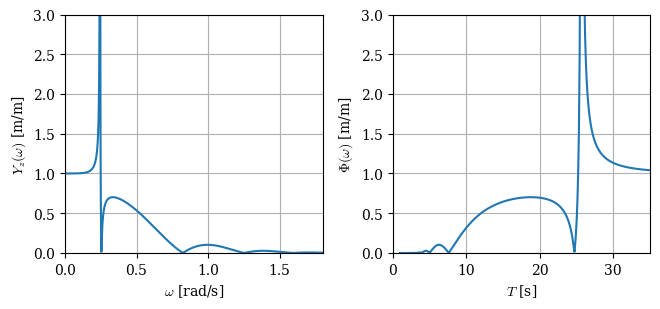

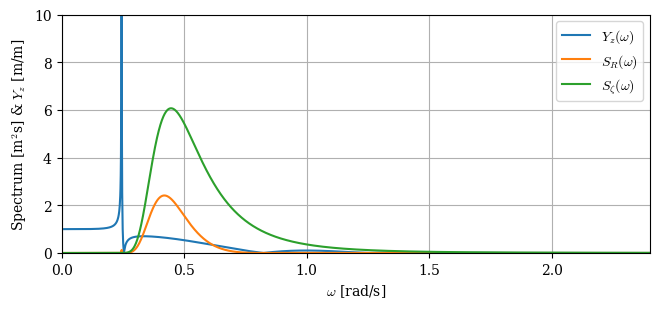

Significant response period T_z,R = 13.638 s
Estimated cycles to failure Nx = 1.000e+00


In [1]:
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "axes.unicode_minus": False
})

# --- Given parameters ---
T = 18.5       # [s]
L = 72.3       # [m]
D = 11.3       # [m]
a = 30.5       # [m]
b = 5.40       # [m]
d = 13.1       # [m]
f = 7.70       # [m]
rho_water = 1025  # [kg/m^3]
g = 9.81       # [m/s^2]
H_s = 5.5      # [m]

# Frequency vector
omg = np.arange(0.01, 2 * np.pi, 0.001)

# --- 7. Geometry and masses ---
A_pontoon = (2 * b)**2
print(f"A_pontoon: {A_pontoon}")

V_pontoon_large = L * A_pontoon
print(f"V_pontoon_large: {V_pontoon_large}")

V_pontoon_small = (L - 4 * b) * A_pontoon
print(f"V_pontoon_small: {V_pontoon_small}")

V_column = f * np.pi * (D / 2)**2
print(f"V_column: {V_column}")

V_platform = 2 * V_pontoon_large + 2 * V_pontoon_small + 4 * V_column
print(f"V_platform: {V_platform}")

M_platform = V_platform * rho_water
print(f"M_platform: {M_platform}")

c_m = 1.51
print(f"c_m: {c_m}")

A_R = np.pi * b**2
print(f"A_R: {A_R}")

hydro_mass_per_length = rho_water * c_m * A_R
print(f"hydro_mass_per_length: {hydro_mass_per_length}")

added_mass_large = hydro_mass_per_length * L
print(f"added_mass_large: {added_mass_large}")

added_mass_small = hydro_mass_per_length * (L - 4 * b)
print(f"added_mass_small: {added_mass_small}")

total_added_mass = 2 * added_mass_large + 2 * added_mass_small
print(f"total_added_mass: {total_added_mass}")

M = M_platform
print(f"M: {M}")

M_a = total_added_mass
print(f"M_a: {M_a}")

# --- 9. Natural frequency and period ---
A_w = 4 * (np.pi * (D / 2)**2)
omeg_N = np.sqrt(rho_water * g * A_w / (M + M_a))
T_N = 2 * np.pi / omeg_N
print(f"Natural frequency ω_N = {omeg_N:.4f} rad/s, period T_N = {T_N:.4f} s")

# --- 10. Frequency response ---
t = 1.0
zeta_a = H_s / 2
k = omg**2 / g

# Forces on pontoons and columns
F_small = (
    -2 * rho_water * (A_pontoon + c_m*A_R) * (L - 4*b)
    * zeta_a * k * g * np.exp(-k*d) * np.cos(k*a) * np.cos(omg*t)
)
F_large = (
    -2 * np.exp(-k*d) * omg**2 * rho_water * zeta_a
    * (np.sin((k*L)/2 + omg*t) + np.sin((k*L)/2 - omg*t))
    * (A_R*c_m + A_pontoon) / k
)
F_column = (
    A_w * zeta_a * rho_water * g * np.exp(-k*f)
    * np.cos(k*a) * np.cos(omg*t)
)
F_total = F_small + F_large + F_column

# Avoid division by zero when cos(omg*t)=0
cos_ot = np.cos(omg*t)
eps = 1e-8
valid = np.abs(cos_ot) > eps
F_z = np.zeros_like(F_total)
F_z[valid] = F_total[valid] / cos_ot[valid]

# Structural restoring term, avoid zero
den = -(M + M_a)*omg**2 + rho_water*g*A_w
safe_den = np.where(np.abs(den) < eps, np.sign(den)*eps, den)

z_0 = F_z / safe_den
Y_z = np.abs(z_0 / zeta_a)

# Plot frequency response
plt.figure(figsize=(6.7, 3.2))
plt.subplot(1, 2, 1)
plt.plot(omg, Y_z)
plt.ylim(0, 3); plt.xlim(0, 1.8)
plt.xlabel(r"$\omega$ [rad/s]")
plt.ylabel(r"$Y_z(\omega)$ [m/m]")
plt.grid(True)

plt.subplot(1, 2, 2)
T_z = 2 * np.pi / omg
plt.plot(T_z, Y_z)
plt.ylim(0, 3); plt.xlim(0, 35)
plt.xlabel(r"$T$ [s]")
plt.ylabel(r"$\Phi(\omega)$ [m/m]")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 11. Response spectrum ---
T_z_spec = 10.0
A = H_s**2/(4*np.pi) * (2*np.pi/T_z_spec)**4
B = (2*np.pi/T_z_spec)**4 / np.pi
S_wave = A / omg**5 * np.exp(-B / omg**4)
S_R = Y_z**2 * S_wave

plt.figure(figsize=(6.7,3.2))
plt.plot(omg, Y_z, label=r"$Y_z(\omega)$")
plt.plot(omg, S_R, label=r"$S_R(\omega)$")
plt.plot(omg, S_wave, label=r"$S_{\zeta}(\omega)$")
plt.xlim(0,2.4); plt.ylim(0,10)
plt.xlabel(r"$\omega$ [rad/s]")
plt.ylabel(r"Spectrum [m$^2$s] & $Y_z$ [m/m]")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

# --- 12. Statistical moments & fatigue life estimate ---
tMPL = 2 * 3600  # [s]
ms = [np.trapz(omg**n * S_R, omg) for n in (0,1,2)]

m0, m2 = ms[0], ms[2]
T_z_R = 2*np.pi * np.sqrt(m0/m2)
N = tMPL / T_z_R
MPL = np.sqrt(2*m0 * np.log(N))
Nx = N * np.exp(-MPL**2/(2*m0))
print(f"Significant response period T_z,R = {T_z_R:.3f} s")
print(f"Estimated cycles to failure Nx = {Nx:.3e}")
